# Augmenting time-series data
In this file, the data is augmented in order to create more of it.

In [15]:
# Imports
import sys

sys.path.insert(1, "../")
import Tools.data_processing as dp
import Tools.data_movement as dm
import Tools.augmentation_helpers as augment
import pandas as pd
from datetime import timedelta
import copy
import random
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from scipy import interpolate
import numpy as np
import scipy.ndimage as ndimage
import csv
from Tools.get_candidates import (
    get_cands_fDOM_NAP,
    get_cands_fDOM_PLP,
    get_cands_fDOM_PP,
    get_cands_fDOM_SKP,
    get_cands_fDOM_FPT,
    get_cands_fDOM_FSK,
    get_cands_turb_PP,
    get_cands_turb_SKP,
    get_cands_turb_FPT,
    get_cands_turb_NAP,
)


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

We define two constants for use with augmenting the data:

1. `TIME_RANGE_INIT`: the number of points before and after the relative peak that we take data from
2. `ITERATIONS`: the number of times we loop over the list of anomaly peaks, and augment them
3. `STARTING_TIMESTAMP`: the timestamp to start all augmented data at. The default value is 15 minutes after the last data measurement from the original set up data given to the project devs. As of 2/16/22, this timestamp is correct.
4. `LOWER_BOUND_AMPLITUDE_MULTIPLIER`: the lower bound of the amplitude augment multiplier
5. `UPPER_BOUND_AMPLITUDE_MULTIPLIER`: the upper bound of the amplitude augment multiplier
6. `SMOOTH_LOWER_BOUND`: lower bound for number of points to cover when adding smoothing data
7. `SMOOTH_UPPER_BOUND`: upper bound for number of points to cover when adding smoothing data


In [17]:
""" Helpful constants """
TIME_RANGE_INIT = 30  # the base time range for peaks, in number of data points(MUST BE 1 OR HIGHER), this is used as a fallback
ITERATIONS = 1  # number of times to loop over dataset and augment
STARTING_TIMESTAMP = 2459096.9583333335

LOWER_BOUND_AMPLITUDE_MULTIPLIER = -0.1
UPPER_BOUND_AMPLITUDE_MULTIPLIER = 0.1

# when these values are higher (>40), the augmented data looks wonky
SMOOTH_LOWER_BOUND = 200  # the minimum amount of data points to cover when smoothing
SMOOTH_UPPER_BOUND = 400  # the maximum amount of data points to cover when smoothing

# flat level average vals
FLAT_FDOM_VAL = 15
FLAT_TURB_VAL = 18
FLAT_STAGE_VAL = 0.2


## Loading in data
The knowledge-based approach uses the data in `Data/converted_data/julian_format/`, so that is where the data augmentation will go.

In [27]:
# Read in raw data
fDOM_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/fDOM_raw_10.1.2011-9.4.2020.csv"
)
stage_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/stage_10.1.11-1.1.19.csv"
)
turb_data = dm.read_in_preprocessed_timeseries(
    "../Data/converted_data/julian_format/turbidity_raw_10.1.2011_9.4.2020.csv"
)

# align stage to fDOM
stage_data = dp.align_stage_to_fDOM(fDOM_data, stage_data)

# read in labeled fDOM
fDOM_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/fDOM/fDOM_all_julian_0k-300k.csv"
)

# read in labeled turb
turb_labeled = pd.read_csv(
    "../Data/labeled_data/ground_truths/turb/turb_all_julian_0k-300k.csv"
)

# Convert data into pandas dataframes for better indexing:
fDOM_raw = pd.DataFrame(fDOM_data)
fDOM_raw.columns = ["timestamp", "value"]

turb_raw = pd.DataFrame(turb_data)
turb_raw.columns = ["timestamp", "value"]

stage_raw = pd.DataFrame(stage_data)
stage_raw.columns = ["timestamp", "value"]


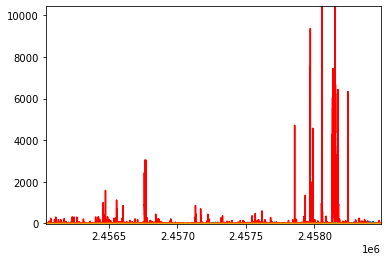

In [19]:
"""
Visualize data
"""
fig = plt.figure()
x = fDOM_raw['timestamp']
y = turb_raw['value']

line_fdom = plt.Line2D(fDOM_raw['timestamp'], fDOM_raw['value'])
line_turb = plt.Line2D(turb_raw['timestamp'], turb_raw['value'], color='red')
line_stage = plt.Line2D(stage_raw['timestamp'], stage_raw['value'], color='orange')
ax = fig.add_subplot(111)

ax.add_line(line_fdom)
ax.add_line(line_turb)
ax.add_line(line_stage)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y) - 10, max(y) + 10)

plt.show()

## Augmenting Data
We will augment data for each type of peak, and for each measurement.

Starting with fDOM:
1. PLP (plummeting peak)
2. PP (phantom peak)
3. SKP (skyrocketing peak)

TODO: augment more peak types when they are labeled

With turbidity:
1. PP

### Augmenting fDOM

In [ ]:
#####################################################################################
#                                                                                   #
#                               DATAFRAME SETUP SECTION                             #
#                                                                                   #
#####################################################################################

# new dataframes for augmented labeled/raw fDOM
augmented_fDOM_raw = pd.DataFrame(columns=["timestamp", "value"])
augmented_fDOM_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# dataframe for stage to align with augmented fDOM
augmented_stage_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])

# dataframes for turbidity to align with augmented fDOM
augmented_turb_raw_fdom = pd.DataFrame(columns=["timestamp", "value"])


# variable to keep the last entry in the dataframe for stage
# defaults to the last entry that was in fdom/turb raw csv files, in julian format
prev_added_entry = STARTING_TIMESTAMP

# a list of peaks that don't align with the fDOM raw file that was aligned with stage
# i believe its just peaks that don't align with stage in general for whatever reason
missed_fDOM_peaks = []

# ~~~~~ Collect starting and ending points of each fDOM peak type ~~~~~
# PP
fdom_pp_index_lookup = get_cands_fDOM_PP()

## SKP
fdom_skp_index_lookup = get_cands_fDOM_SKP()

## PLP
fdom_plp_index_lookup = get_cands_fDOM_PLP()

# flat plateaus (FPT)
fdom_fpt_index_lookup = get_cands_fDOM_FPT()

# flat sinks
fdom_fsk_index_lookup = get_cands_fDOM_FSK()

# non anomaly peaks
fdom_NAP_index_lookup = get_cands_fDOM_NAP()

#####################################################################################
#                                                                                   #
#                               AUGMENT DATA SECTION                                #
#                                                                                   #
#####################################################################################

for iteration in range(ITERATIONS):
    """
    Re-sample the fDOM labeled peaks to add variance to data
    """
    # labeled fDOM peaks
    fdom_anon_peaks = fDOM_labeled[fDOM_labeled["label_of_peak"] != "NAP"]
    # randomize the order, to add more variability to data
    fdom_anon_peaks = fdom_anon_peaks.sample(frac=1).reset_index(
        drop=True
    )  # reset index as values were removed

    # labeled non anomaly fDOM peaks
    fdom_NAP = fDOM_labeled[fDOM_labeled["label_of_peak"] == "NAP"]
    fdom_NAP = fdom_NAP.sample(frac=1).reset_index(drop=True)

    # iterate over each peak
    for i, row in fdom_anon_peaks.iterrows():
        # Get raw fDOM data points
        label_of_peak = fdom_anon_peaks.loc[i, "label_of_peak"]

        prev_dist = TIME_RANGE_INIT
        next_dist = TIME_RANGE_INIT

        prev_dist_NAP = TIME_RANGE_INIT
        next_dist_NAP = TIME_RANGE_INIT

        # set cands_df based on our peak label
        if label_of_peak == "PP":
            cands_df = fdom_pp_index_lookup
        elif label_of_peak == "PLP":
            cands_df = fdom_plp_index_lookup
        elif label_of_peak == "SKP":
            cands_df = fdom_skp_index_lookup
        elif label_of_peak == "FSK":
            cands_df = fdom_fsk_index_lookup
        elif label_of_peak == "FPT":
            cands_df = fdom_fpt_index_lookup


        timestamp_of_peak = fdom_anon_peaks.loc[i, "timestamp_of_peak"]

        NAP_index = fdom_NAP.loc[i, "idx_of_peak"]
        timestamp_NAP = fDOM_raw.loc[NAP_index, "timestamp"]

        # get index dataframes of each type
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        # get indices of non anomaly data
        stage_index_df_NAP = stage_raw[stage_raw["timestamp"] == timestamp_NAP]
        turb_index_df_NAP = turb_raw[turb_raw["timestamp"] == timestamp_NAP]

        if len(fdom_index_df.index.to_list()) != 0:
            # get indices of each data type from index df's
            index_of_peak = fdom_index_df.index.tolist()[0]
            stage_index = stage_index_df.index.tolist()[0]
            turb_index = turb_index_df.index.tolist()[0]

            # get indices of NAP (might break, try except to catch that)
            stage_index_NAP = stage_index_df_NAP.index.tolist()[0]
            turb_index_NAP = turb_index_df_NAP.index.tolist()[0]

            # call get ends of peak to get beginning and ending of peaks
            try:
                left, right = augment.get_ends_of_peak(cands_df, index_of_peak)

                prev_dist = abs(index_of_peak - left)
                next_dist = abs(index_of_peak - right)

            except IndexError as e:
                # something went wrong, just set prev_dist and next dist to time range init
                prev_dist = TIME_RANGE_INIT
                next_dist = TIME_RANGE_INIT
                print(e)

            # try except for nap
            try:
                left_NAP, right_NAP = augment.get_ends_of_peak(
                    fdom_NAP_index_lookup, NAP_index
                )

                prev_dist_NAP = abs(NAP_index - left_NAP)
                next_dist_NAP = abs(NAP_index - right_NAP)

            except IndexError as e:
                prev_dist_NAP = TIME_RANGE_INIT
                next_dist_NAP = TIME_RANGE_INIT
                print("INDEX ERROR: " + str(e))

            # use this timestamp to make a dataframe of raw stuff
            # get data from fDOM_raw file
            # call build temp dataframes to build df's:
            new_fdom_raw, new_stage, new_turb_raw = augment.build_temp_dataframes(
                fDOM_raw,
                stage_raw,
                turb_raw,
                prev_dist,
                next_dist,
                index_of_peak,
                stage_index,
                turb_index,
            )

            (
                new_fdom_raw_NAP,
                new_stage_NAP,
                new_turb_raw_NAP,
            ) = augment.build_temp_dataframes(
                fDOM_raw,
                stage_raw,
                turb_raw,
                prev_dist_NAP,
                next_dist_NAP,
                NAP_index,
                stage_index_NAP,
                turb_index_NAP,
            )

            #####################################################################################
            #                                                                                   #
            #                               ACTUAL CHANGES TO DATA                              #
            #                                                                                   #
            #####################################################################################

            # decide whether to augment Non anomaly peak first, or anomaly peak first
            which = random.randint(0, 1)

            # if which is 0, augment NAP first
            if which == 0:

                # ~~~~~~~~~~~ AUGMENTING NAP ~~~~~~~~~
                # augment data
                new_fdom_raw_NAP = augment.augment_data(
                    new_fdom_raw_NAP,
                    NAP_index,
                    LOWER_BOUND_AMPLITUDE_MULTIPLIER,
                    UPPER_BOUND_AMPLITUDE_MULTIPLIER,
                )

                # SMOOTH DATA
                # ensure that main augmented df has more than 1 row, else no data to smooth
                if augmented_fDOM_raw.shape[0] > 1:
                    (
                        augmented_fDOM_raw,
                        augmented_stage_raw_fdom,
                        augmented_turb_raw_fdom,
                        prev_added_entry,
                    ) = augment.smooth_data(
                        augmented_fDOM_raw,
                        augmented_stage_raw_fdom,
                        augmented_turb_raw_fdom,
                        prev_added_entry,
                        SMOOTH_LOWER_BOUND,
                        SMOOTH_UPPER_BOUND,
                        FLAT_FDOM_VAL,
                        FLAT_TURB_VAL,
                        FLAT_STAGE_VAL,
                    )

                (
                    new_label_NAP,
                    new_fdom_raw_NAP,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    prev_added_entry,
                ) = augment.update_dataframes(
                    prev_added_entry,
                    new_fdom_raw_NAP,
                    NAP_index,
                    prev_dist_NAP,
                    augmented_fDOM_raw,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    "NAP",  # NAP label is just NAP
                )

                # call concat dataframes to put the rest together
                (
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                ) = augment.concat_dataframes(
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    new_fdom_raw_NAP,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    new_label_NAP,
                )

                ####### AUGMENT ANOMALY PEAK #######

                # call augment data function
                new_fdom_raw = augment.augment_data(
                    new_fdom_raw,
                    index_of_peak,
                    LOWER_BOUND_AMPLITUDE_MULTIPLIER,
                    UPPER_BOUND_AMPLITUDE_MULTIPLIER,
                )

                # SMOOTH DATA
                (
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    prev_added_entry,
                ) = augment.smooth_data(
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    prev_added_entry,
                    SMOOTH_LOWER_BOUND,
                    SMOOTH_UPPER_BOUND,
                    FLAT_FDOM_VAL,
                    FLAT_TURB_VAL,
                    FLAT_STAGE_VAL,
                )

                # call update dataframes to set new indices and timestamps
                (
                    new_label,
                    new_fdom_raw,
                    new_stage,
                    new_turb_raw,
                    prev_added_entry,
                ) = augment.update_dataframes(
                    prev_added_entry,
                    new_fdom_raw,
                    index_of_peak,
                    prev_dist,
                    augmented_fDOM_raw,
                    new_stage,
                    new_turb_raw,
                    label_of_peak,
                )

                # concat the rest of the peaks
                (
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                ) = augment.concat_dataframes(
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    new_fdom_raw,
                    new_stage,
                    new_turb_raw,
                    new_label,
                )

            # else, augment anomaly first
            else:

                ####### AUGMENT ANOMALY PEAK #######
                # call augment data function
                new_fdom_raw = augment.augment_data(
                    new_fdom_raw,
                    index_of_peak,
                    LOWER_BOUND_AMPLITUDE_MULTIPLIER,
                    UPPER_BOUND_AMPLITUDE_MULTIPLIER,
                )

                # SMOOTH DATA
                # ensure that main augmented df has more than 1 row, else no data to smooth
                if augmented_fDOM_raw.shape[0] > 1:
                    (
                        augmented_fDOM_raw,
                        augmented_stage_raw_fdom,
                        augmented_turb_raw_fdom,
                        prev_added_entry,
                    ) = augment.smooth_data(
                        augmented_fDOM_raw,
                        augmented_stage_raw_fdom,
                        augmented_turb_raw_fdom,
                        prev_added_entry,
                        SMOOTH_LOWER_BOUND,
                        SMOOTH_UPPER_BOUND,
                        FLAT_FDOM_VAL,
                        FLAT_TURB_VAL,
                        FLAT_STAGE_VAL,
                    )

                # call update dataframes to set new indices and timestamps
                (
                    new_label,
                    new_fdom_raw,
                    new_stage,
                    new_turb_raw,
                    prev_added_entry,
                ) = augment.update_dataframes(
                    prev_added_entry,
                    new_fdom_raw,
                    index_of_peak,
                    prev_dist,
                    augmented_fDOM_raw,
                    new_stage,
                    new_turb_raw,
                    label_of_peak,
                )

                # concat the rest of the peaks
                (
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                ) = augment.concat_dataframes(
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    new_fdom_raw,
                    new_stage,
                    new_turb_raw,
                    new_label,
                )

                # ~~~~~~~~~~~ AUGMENTING NAP ~~~~~~~~~
                # augment data
                new_fdom_raw_NAP = augment.augment_data(
                    new_fdom_raw_NAP,
                    NAP_index,
                    LOWER_BOUND_AMPLITUDE_MULTIPLIER,
                    UPPER_BOUND_AMPLITUDE_MULTIPLIER,
                )

                # SMOOTH DATA
                (
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    prev_added_entry,
                ) = augment.smooth_data(
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    prev_added_entry,
                    SMOOTH_LOWER_BOUND,
                    SMOOTH_UPPER_BOUND,
                    FLAT_FDOM_VAL,
                    FLAT_TURB_VAL,
                    FLAT_STAGE_VAL,
                )

                (
                    new_label_NAP,
                    new_fdom_raw_NAP,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    prev_added_entry,
                ) = augment.update_dataframes(
                    prev_added_entry,
                    new_fdom_raw_NAP,
                    NAP_index,
                    prev_dist_NAP,
                    augmented_fDOM_raw,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    "NAP",  # NAP label is just NAP
                )

                # call concat dataframes to put the rest together
                (
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                ) = augment.concat_dataframes(
                    augmented_fDOM_labeled,
                    augmented_fDOM_raw,
                    augmented_stage_raw_fdom,
                    augmented_turb_raw_fdom,
                    new_fdom_raw_NAP,
                    new_stage_NAP,
                    new_turb_raw_NAP,
                    new_label_NAP,
                )

        else:
            # we missed some data points, append them to the missed data dataframe
            missed_fDOM_peaks.append(timestamp_of_peak)


### Augment turbidity data
The following code blocks augment turbidity data.
NOTE: This is currently nonfunctional, and needs to be rewritten using the new functions written.

In [28]:
#####################################################################################
#                                                                                   #
#                               DATAFRAME SETUP SECTION                             #
#                                                                                   #
#####################################################################################

# new dataframes for augmented labeled and raw turb
augmented_turb_raw = pd.DataFrame(columns=["timestamp", "value"])
augmented_turb_labeled = pd.DataFrame(
    columns=["timestamp_of_peak", "value_of_peak", "label_of_peak", "idx_of_peak"]
)

# dataframe for stage to align with augmented turb
augmented_stage_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# dataframes for fDOM to align with augmented turb
augmented_fdom_raw_turb = pd.DataFrame(columns=["timestamp", "value"])

# var to keep last time entry for augmentation
prev_added_entry = STARTING_TIMESTAMP

# missed peaks
missed_turb_peaks = []

# ~~~~~~ Collect starting and ending points of each fDOM peak type
# PP
turb_pp_index_lookup = get_cands_turb_PP()

## SKP
turb_skp_index_lookup = get_cands_turb_SKP()

## FPT
turb_fpt_index_lookup = get_cands_turb_FPT()

# non anomaly peaks
turb_NAP_index_lookup = get_cands_turb_NAP()

#####################################################################################
#                                                                                   #
#                               AUGMENT DATA SECTION                                #
#                                                                                   #
#####################################################################################

for iteration in range(ITERATIONS):
    """
    re-sample fDOM labeled peaks to add variance to data
    """
    # labeled turb peaks
    turb_anon_peaks = turb_labeled[turb_labeled["label_of_peak"] != "NAP"]

    turb_anon_peaks = turb_anon_peaks.sample(frac=1).reset_index(drop=True)

    # labeled non anomaly turb peaks
    turb_NAP = turb_labeled[turb_labeled["label_of_peak"] == "NAP"]
    turb_NAP = turb_NAP.sample(frac=1).reset_index(drop=True)

    # iterate over each peak
    # TODO: ensure looping over anomaly peaks is okay (should be because more NAP, but you never know)
    for i, row in turb_anon_peaks.iterrows():
        label_of_peak = turb_anon_peaks.loc[i, "label_of_peak"]

        prev_dist = TIME_RANGE_INIT
        next_dist = TIME_RANGE_INIT
        prev_dist_NAP = TIME_RANGE_INIT
        next_dist_NAP = TIME_RANGE_INIT

        # set cands df based on current peak label
        if label_of_peak == "SKP":
            cands_df = turb_skp_index_lookup
        elif label_of_peak == "PP":
            cands_df = turb_pp_index_lookup
        elif label_of_peak == "FPT":
            cands_df = turb_fpt_index_lookup

        timestamp_of_peak = turb_anon_peaks.loc[i, "timestamp_of_peak"]

        NAP_index = turb_NAP.loc[i, "idx_of_peak"]
        timestamp_NAP = turb_raw.loc[NAP_index, "timestamp"]

        # get indices
        # TODO: implement from here
        fdom_index_df = fDOM_raw[fDOM_raw["timestamp"] == timestamp_of_peak]
        stage_index_df = stage_raw[stage_raw["timestamp"] == timestamp_of_peak]
        turb_index_df = turb_raw[turb_raw["timestamp"] == timestamp_of_peak]

        # get indices of NAP
        stage_index_df_NAP = stage_raw[stage_raw["timestamp"] == timestamp_NAP]
        fdom_index_df_NAP = fDOM_raw[fDOM_raw["timestamp"] == timestamp_NAP]

        if len(turb_index_df.index.to_list()) != 0:
            index_of_peak = int(turb_index_df.index.tolist()[0])
            stage_index = int(stage_index_df.index.tolist()[0])
            fdom_index = int(fdom_index_df.index.tolist()[0])

            stage_index_NAP = int(stage_index_df_NAP.index.tolist()[0])
            fdom_index_NAP = int(fdom_index_df_NAP.index.tolist()[0])

            try:
                left, right = augment.get_ends_of_peak(cands_df, index_of_peak)

                prev_dist = int(abs(index_of_peak - left))
                next_dist = int(abs(index_of_peak - right))
            
            except IndexError as e:
                prev_dist = TIME_RANGE_INIT
                next_dist = TIME_RANGE_INIT

            try:
                left_NAP, right_NAP = augment.get_ends_of_peak(
                    turb_NAP_index_lookup, NAP_index
                )

            except IndexError as e:
                prev_dist_NAP = TIME_RANGE_INIT
                next_dist_NAP = TIME_RANGE_INIT
            
            # TODO: implement build temp dataframes
            new_fdom_raw, new_stage, new_turb_raw = augment.build_temp_dataframes(
                fDOM_raw,
                stage_raw,
                turb_raw,
                prev_dist,
                next_dist,
                fdom_index,
                stage_index,
                index_of_peak,
            )

            new_fdom_raw_NAP, new_stage_NAP, new_turb_raw_NAP = augment.build_temp_dataframes(
                fDOM_raw,
                stage_raw,
                turb_raw,
                prev_dist_NAP,
                next_dist_NAP,
                fdom_index_NAP,
                stage_index_NAP,
                NAP_index
            )

            #####################################################################################
            #                                                                                   #
            #                               ACTUAL CHANGES TO DATA                              #
            #                                                                                   #
            #####################################################################################

            # decide whether to augment non anomaly or anomaly first

## Move augmented data into csv files
The following codeblock creates csv files for the augmented data.

In [ ]:
""" Augmented Data Paths """
# trainset
trainset_fdom_path = "../Data/augmented_data/trainset_plotting/fdom/"
trainset_turb_path = "../Data/augmented_data/trainset_plotting/turb/"

# unlabeled data
unlabeled_fdom_path = "../Data/augmented_data/fdom/unlabeled/"
unlabeled_turb_path = "../Data/augmented_data/turb/unlabeled/"

# labeled data
labeled_fdom_path = "../Data/augmented_data/fdom/labeled/"
labeled_turb_path = "../Data/augmented_data/turb/labeled/"

# write to normal julian csv
# augment.write_augmented_data_to_csv(
#     labeled_fdom_path,
#     unlabeled_fdom_path,
#     labeled_turb_path,
#     unlabeled_turb_path,
#     augmented_fDOM_labeled,
#     augmented_fDOM_raw,
#     augmented_turb_raw_fdom,
#     augmented_stage_raw_fdom,
#     augmented_turb_labeled,
#     augmented_turb_raw,
#     augmented_fDOM_raw_turb,
#     augmented_stage_raw_turb,
# )

# write to trainset
augment.write_to_trainset_csv(
    augmented_fDOM_raw,
    augmented_turb_raw_fdom,
    augmented_stage_raw_fdom,
    trainset_fdom_path,
    augmented_turb_raw,
    augmented_fDOM_raw_turb,
    augmented_stage_raw_turb,
    trainset_turb_path,
)
